In [1]:
import pandas as pd
import numpy as np
from time import process_time
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from data_preprocessing import *
from model import *

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM, Bidirectional, Conv1D, Dropout, SpatialDropout2D, concatenate
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
corpus = []
for text in x_train:
    corpus.append(text)
print(len(corpus))
for text in x_val:
    corpus.append(text)
print(len(corpus))

41997
45777


In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(corpus, x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [14]:
#with open( "../tokenizers/DL-tokenizer-train-val-100.pkl", "wb") as token_file:
#    pickle.dump(tokenizer, token_file)

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab)

55100

# Domain Specific Fasttext Embeddings

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.complete.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

53723
Total time taken:  21.412040841000003


(55101, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  55101
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# Indic-Fasttext Embeddings

In [15]:
start = process_time()
embedding_path2 = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_matrix2 = get_embedding_matrix(embedding_path2, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix2.shape

30591
Total time taken:  27.751925592


(55101, 300)

In [16]:
input_dim2 = embedding_matrix2.shape[0]
embedding_dim2 = 300
input_len = pad_len
print("Input dimension 2: ", input_dim2)
print("Embedding dimensions 2: ", embedding_dim2)
print("Input sentence dimensions 2: ", input_len)

Input dimension 2:  55101
Embedding dimensions 2:  300
Input sentence dimensions 2:  100


# Attention Layer

In [17]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        super(AttentionLayer, self).build(attention_input)
        emb1, emb2 = attention_input
        # Attention Weights for LSTM
        self.W_in = self.add_weight(shape=(emb1[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
        
        # Attention Weights for CNN
        self.W_context = self.add_weight(shape=(emb2[-1], 1),
                                         initializer='glorot_normal',
                                         trainable=True,
                                         name='context_attention_weights')
                                      
        # Attention Bias
        self.b = self.add_weight(shape=(emb1[1], 1),
                                 initializer='glorot_normal',
                                 trainable=True,
                                 name='attention_bias')
        
        
        
    def call(self, attention_input):
        emb1, emb2 = attention_input
        et = K.squeeze(K.tanh(K.dot(emb1, self.W_in) + 
                              K.dot(emb2, self.W_context) +
                              self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = at * emb1
        #attention_output = K.sum(attention_output, axis=1)
        return attention_output
    
    
    def compute_output_shape(self, attention_input):
        return (attention_input[0], attention_input[-1])
    
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

# Domain Specific + Indic-Fasttext multi-input architecture

In [34]:
inputs = Input(shape=(input_len,))

# Input 1(Domain Specific Fasttext Embeddings):
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(inputs)

# Input 2 (Indic-Fasttext Embeddings):
Embedding_layer2 = Embedding(input_dim=input_dim2,
                             output_dim=embedding_dim2, 
                             weights=[embedding_matrix2], 
                             trainable=False)(inputs)

attention_output = AttentionLayer()([Embedding_layer1, Embedding_layer2])
lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(attention_output)
max_pooling = GlobalMaxPooling1D()(lstm)
Dense1 = Dense(64, activation='relu')(max_pooling)
Dropout3 = Dropout(0.3)(Dense1)
outputs = Dense(4, activation='softmax')(Dropout3)

classifier = Model(inputs=inputs, outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 300)     16530300    input_8[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 300)     16530300    input_8[0][0]                    
__________________________________________________________________________________________________
attention_layer_5 (AttentionLay (None, 100, 300)     700         embedding_10[0][0]               
                                                                 embedding_11[0][0]         

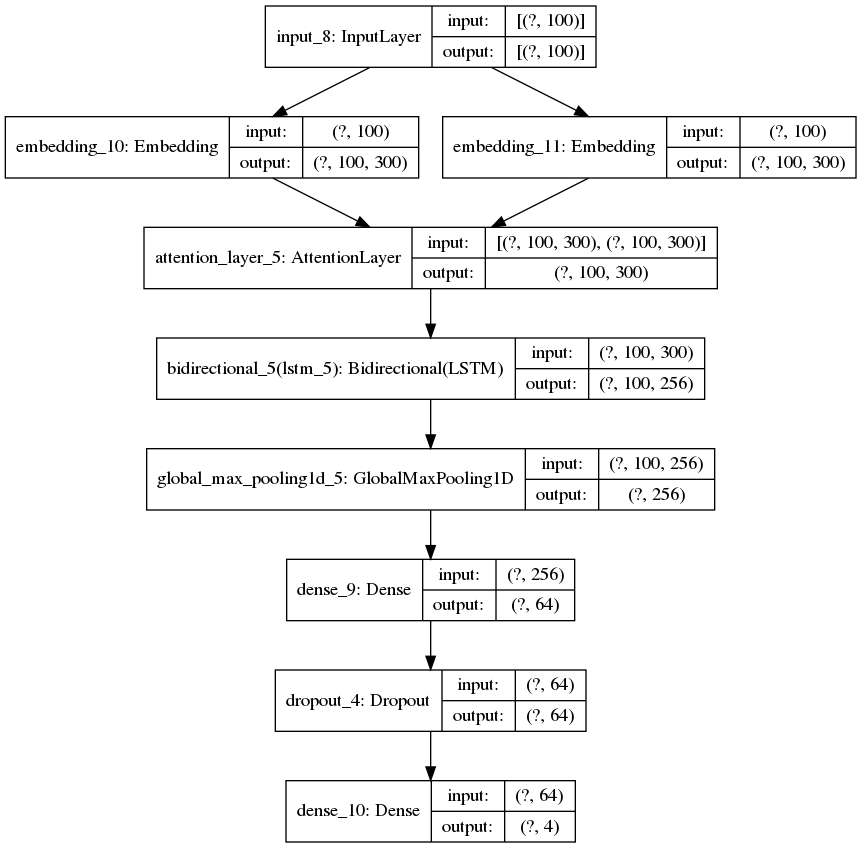

In [35]:
plot_model(classifier, show_shapes=True)

In [36]:
checkpoint_filepath = "../models/multi-embeddings-BiLSTM/multi-embeddings-BiLSTM.epoch-{epoch:02d}.val-acc-{val_acc:02f}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_acc',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback = ReduceLROnPlateau( monitor='val_acc', 
                                       factor=0.2, 
                                       patience=2, 
                                       min_lr=0.0005, 
                                       verbose=2)

#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [37]:
history = classifier.fit([x_train_padded, x_train_padded], 
                         y_train, 
                         epochs=16,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, x_val_padded], y_val),
                         callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/16
329/329 [==============================] - 266s 809ms/step - loss: 0.8593 - acc: 0.6528 - val_loss: 0.4672 - val_acc: 0.8373 - lr: 0.0010
Epoch 2/16
329/329 [==============================] - 257s 780ms/step - loss: 0.4601 - acc: 0.8373 - val_loss: 0.4005 - val_acc: 0.8537 - lr: 0.0010
Epoch 3/16
329/329 [==============================] - 259s 788ms/step - loss: 0.4134 - acc: 0.8527 - val_loss: 0.3746 - val_acc: 0.8635 - lr: 0.0010
Epoch 4/16
329/329 [==============================] - 290s 881ms/step - loss: 0.3931 - acc: 0.8616 - val_loss: 0.3628 - val_acc: 0.8683 - lr: 0.0010
Epoch 5/16
329/329 [==============================] - 282s 857ms/step - loss: 0.3774 - acc: 0.8665 - val_loss: 0.3759 - val_acc: 0.8685 - lr: 0.0010
Epoch 6/16
329/329 [==============================] - 260s 789ms/step - loss: 0.3668 - acc: 0.8694 - val_loss: 0.3586 - val_acc: 0.8706 - lr: 0.0010
Epoch 7/16
329/329 [==============================] - 259s 789ms/step - loss: 0.3624 - acc: 0.8705 - val_l

KeyboardInterrupt: 

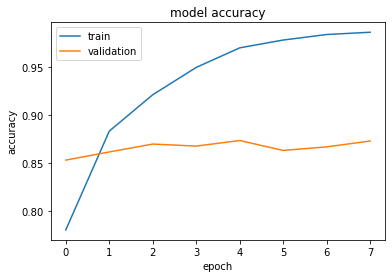

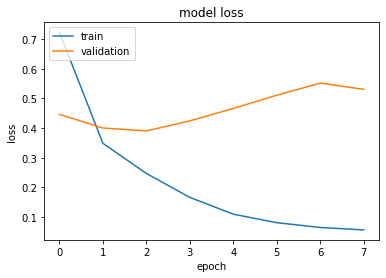

In [67]:
plot_curves(history)

In [68]:
results1 = np.argmax(classifier.predict([x_val_padded, x_val_padded]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.873015873015873

Precision:  [0.83123426 0.86683261 0.91727494 0.86268344]
Average Precision:  0.8695063103994282

Recall:  [0.78571429 0.9255814  0.8519774  0.84845361]
Average Recall:  0.8529316726101223

F1-Score:  [0.80783354 0.89524422 0.88342121 0.85550936]
Average F1-Score:  0.8605020788937269


In [70]:
save_model(classifier, "multi-channel-CNN/multi-channel-CNN-valacc-8730")